In [1]:
#!/usr/bin/env python
import numpy as np
import random
from tqdm import tqdm
import pickle

np.set_printoptions(precision=4, suppress=True)

# ------------------------------
# Q-Learning Code Implementation
# ------------------------------
class GridworldEnv:
    def __init__(self, grid_size=(4, 4)):
        self.rows, self.cols = grid_size
        # Define special states with forced destination and reward.
        self.special_states = {
            (0, 1): {'dest': (3, 1), 'reward': 10},
            (0, 3): {'dest': (2, 3), 'reward': 5}
        }
        # Actions: 0: left, 1: up, 2: right, 3: down.
        self.actions = {
            0: (0, -1),
            1: (-1, 0),
            2: (0, 1),
            3: (1, 0)
        }
        self.action_list = [0, 1, 2, 3]
        self.intended_prob = 0.9
        self.slip_prob = 0.05  # probability for each perpendicular move

    def in_bounds(self, state):
        r, c = state
        return 0 <= r < self.rows and 0 <= c < self.cols

    def get_perpendicular_actions(self, action):
        if action in [0, 2]:
            return [1, 3]
        elif action in [1, 3]:
            return [0, 2]
        else:
            return []

    def get_outcomes(self, state, action):
        """
        Computes all possible outcomes for a given state and action.
        Returns a list of tuples: (probability, next_state, reward)
        following the dynamics of the gridworld.
        """
        if state in self.special_states:
            forced_dest = self.special_states[state]['dest']
            reward = self.special_states[state]['reward']
            return [(1.0, forced_dest, reward)]

        outcomes = []
        intended_action = action
        base_reward = 0
        probs = [self.intended_prob, self.slip_prob, self.slip_prob]
        actions_to_consider = [intended_action] + self.get_perpendicular_actions(intended_action)
        for act, p in zip(actions_to_consider, probs):
            dr, dc = self.actions[act]
            next_state = (state[0] + dr, state[1] + dc)
            if not self.in_bounds(next_state):
                outcomes.append((p, state, -1))
            else:
                outcomes.append((p, next_state, base_reward))
        return outcomes

def compute_optimal_Q(env, gamma=0.9, tol=1e-9, max_iter=10000):
    """
    Compute the optimal Q-function Q* using value iteration.
    Returns Q* as a (rows x cols x num_actions) numpy array.
    """
    Q = np.zeros((env.rows, env.cols, len(env.action_list)))
    for it in range(max_iter):
        Q_new = np.zeros_like(Q)
        for r in range(env.rows):
            for c in range(env.cols):
                state = (r, c)
                for a in env.action_list:
                    if state in env.special_states:
                        forced_dest = env.special_states[state]['dest']
                        reward = env.special_states[state]['reward']
                        Q_new[r, c, a] = reward + gamma * np.max(Q[forced_dest[0], forced_dest[1]])
                    else:
                        probs = [env.intended_prob, env.slip_prob, env.slip_prob]
                        actions_to_consider = [a] + env.get_perpendicular_actions(a)
                        value = 0.0
                        for p, act in zip(probs, actions_to_consider):
                            dr, dc = env.actions[act]
                            next_state = (r + dr, c + dc)
                            if not env.in_bounds(next_state):
                                value += p * (-1 + gamma * np.max(Q[r, c]))
                            else:
                                value += p * (0 + gamma * np.max(Q[next_state[0], next_state[1]]))
                        Q_new[r, c, a] = value
        err = np.max(np.abs(Q_new - Q))
        Q = Q_new
        if err < tol:
            print(f"Value iteration converged in {it+1} iterations with error {err:.2e}.")
            break
    return Q

class QLearningAgent:
    def __init__(self, env, alpha_constant=0.1,alpha_diminishing=0.5, gamma=0.9):
        self.env = env
        self.alpha_constant = alpha_constant      # learning rate
        self.alpha_diminishing = alpha_diminishing 
        self.gamma = gamma      # discount factor
        #self.epsilon = epsilon  # exploration rate
        self.Q = np.zeros((env.rows, env.cols, len(env.action_list)))

def run_q_learning(Q_star,constant_steps=5, diminishing_steps=2, alpha_constant=0.05, alpha_diminishing=0.05,
                   gamma=0.7, beta=0.65):
    env = GridworldEnv()
    agent = QLearningAgent(env, alpha_constant=alpha_constant, alpha_diminishing=alpha_diminishing, gamma=gamma)
    #Q_star = compute_optimal_Q(env, gamma=gamma)

    Q_traj = agent.Q.copy() 
    #print(Q_traj)
    # List to store copies of the Q-function.
    branch_probs = [env.intended_prob, env.slip_prob, env.slip_prob]
    error_history = []   # To record the sup-norm error after each episode
    partial_sum = np.zeros_like(Q_star)
    max_norm = 0.0

    for t in tqdm(range(constant_steps), desc="constant steps", ncols=100, position=0):
        branch = np.random.choice([0, 1, 2], p=branch_probs)
        for r in range(env.rows):
            for c in range(env.cols):
                s = (r, c)
                for a in env.action_list:
                    if s in env.special_states:
                        forced_dest = env.special_states[s]['dest']
                        reward = env.special_states[s]['reward']
                        bellman_op = reward + gamma * np.max(Q_traj[forced_dest[0], forced_dest[1]])
                    else:
                        outcomes = env.get_outcomes(s, a)
                        _, s_next, r_val = outcomes[branch]
                        bellman_op = r_val + gamma * np.max(Q_traj[s_next[0], s_next[1]])
                    agent.Q[r, c, a] = (1 - alpha_constant) * agent.Q[r, c, a] + alpha_constant * bellman_op
        Q_traj = agent.Q.copy()
        error_history.append(np.max(np.abs(Q_traj - Q_star)))
        partial_sum += (Q_traj - Q_star)
        current_norm = np.max(np.abs(partial_sum))
        if current_norm > max_norm:
            max_norm = current_norm
        #print(Q_traj)
        
    #partial_sum = np.zeros_like(Q_star)
    #max_norm = 0.0
    
    for t in tqdm(range(diminishing_steps), desc="diminishing steps", ncols=100, position=0):
        branch = np.random.choice([0, 1, 2], p=branch_probs)
        for r in range(env.rows):
            for c in range(env.cols):
                s = (r, c)
                for a in env.action_list:
                    if s in env.special_states:
                        forced_dest = env.special_states[s]['dest']
                        reward = env.special_states[s]['reward']
                        bellman_op = reward + gamma * np.max(Q_traj[forced_dest[0], forced_dest[1]])
                    else:
                        outcomes = env.get_outcomes(s, a)
                        _, s_next, r_val = outcomes[branch]
                        bellman_op = r_val + gamma * np.max(Q_traj[s_next[0], s_next[1]])
                    lr = alpha_diminishing * ((t + 1) ** (-beta))
                    agent.Q[r, c, a] = (1 - lr) * agent.Q[r, c, a] + lr * bellman_op
        Q_traj = agent.Q.copy()
        #print(Q_traj)
        error_history.append(np.max(np.abs(Q_traj - Q_star)))
        partial_sum += (Q_traj - Q_star)
        current_norm = np.max(np.abs(partial_sum))
        if current_norm > max_norm:
            max_norm = current_norm
                    
    return agent, env, max_norm, error_history, Q_traj

def run_q_learning_LD2Z(Q_star,steps=2, gamma=0.7, eta=0.65, power=1):
    env = GridworldEnv()
    agent = QLearningAgent(env, alpha_constant=alpha_constant, alpha_diminishing=alpha_diminishing, gamma=gamma)
    #Q_star = compute_optimal_Q(env, gamma=gamma)

    Q_traj = agent.Q.copy() 
    #print(Q_traj)
    # List to store copies of the Q-function.
    branch_probs = [env.intended_prob, env.slip_prob, env.slip_prob]
    error_history = []   # To record the sup-norm error after each episode
    
    partial_sum = np.zeros_like(Q_star)
    max_norm = 0.0

    for t in tqdm(range(steps), desc="Linearly decaying steps", ncols=100, position=0):
        branch = np.random.choice([0, 1, 2], p=branch_probs)
        for r in range(env.rows):
            for c in range(env.cols):
                s = (r, c)
                for a in env.action_list:
                    if s in env.special_states:
                        forced_dest = env.special_states[s]['dest']
                        reward = env.special_states[s]['reward']
                        bellman_op = reward + gamma * np.max(Q_traj[forced_dest[0], forced_dest[1]])
                    else:
                        outcomes = env.get_outcomes(s, a)
                        _, s_next, r_val = outcomes[branch]
                        bellman_op = r_val + gamma * np.max(Q_traj[s_next[0], s_next[1]])
                    
                    lr = eta * ((1- t/steps)** power)
                    agent.Q[r, c, a] = (1 - lr) * agent.Q[r, c, a] + lr * bellman_op
        Q_traj = agent.Q.copy()
        #print(Q_traj)
        error_history.append(np.max(np.abs(Q_traj - Q_star)))
        partial_sum += (Q_traj - Q_star)
        current_norm = np.max(np.abs(partial_sum))
        if current_norm > max_norm:
            max_norm = current_norm
        #print(Q_traj)
    return agent, env, max_norm, error_history, Q_traj



In [2]:
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

def run_single_q_learning(seed, Q_star, constant_steps, diminishing_steps, alpha_constant, alpha_diminishing, gamma, beta):
    np.random.seed(seed)
    random.seed(seed)
    _, _, max_norm, error_history, Q_traj = run_q_learning(Q_star = Q_star,
        constant_steps=constant_steps,
        diminishing_steps=diminishing_steps,
        alpha_constant= alpha_constant, 
        alpha_diminishing=alpha_diminishing,
        gamma=gamma,
        beta=beta
    )
    return max_norm, error_history, Q_traj

def run_single_q_learning_LD2Z(seed, Q_star, steps, gamma, eta, power):
    np.random.seed(seed)
    random.seed(seed)
    _, _, max_norm, error_history, Q_traj = run_q_learning_LD2Z(Q_star = Q_star,
        steps=steps,
        gamma=gamma,
        eta=eta,
        power=power
    )
    return max_norm, error_history, Q_traj

def run_experiments_parallel(B, Q_star, constant_steps_1, constant_steps_2, diminishing_steps, alpha_constant, alpha_diminishing,
                             gamma, beta, steps, eta, n_jobs=5):
    seeds = list(range(B))
    
        
        
    with tqdm_joblib(tqdm(total=B, desc="Running experiments with constant step-sizes", ncols=100)):
        results_const = Parallel(n_jobs=n_jobs)(
            delayed(run_single_q_learning)(seed, Q_star, constant_steps_2, constant_steps_1,
                                        alpha_constant, alpha_diminishing, gamma, beta)
        for seed in seeds
    )
        
    with tqdm_joblib(tqdm(total=B, desc="Running experiments with polynomial step-sizes", ncols=100)):
        results_poly = Parallel(n_jobs=n_jobs)(
            delayed(run_single_q_learning)(seed, Q_star, constant_steps_1, diminishing_steps,
                                            alpha_constant, alpha_diminishing, gamma, beta)
            for seed in seeds
        )

    
    with tqdm_joblib(tqdm(total=B, desc="Running experiments with linearly decaying step-sizes", ncols=100)):
        results_LD2Z = Parallel(n_jobs=n_jobs)(
            delayed(run_single_q_learning_LD2Z)(seed, Q_star, steps, gamma, eta, power=1)
            for seed in seeds
        )
        
    with tqdm_joblib(tqdm(total=B, desc="Running experiments with pdtz-mu decaying step-sizes", ncols=100)):
        results_PDTZ_2= Parallel(n_jobs=n_jobs)(
            delayed(run_single_q_learning_LD2Z)(seed, Q_star, steps, gamma, eta, power=2)
            for seed in seeds
        )
        
    with tqdm_joblib(tqdm(total=B, desc="Running experiments with pdtz-mu decaying step-sizes", ncols=100)):
        results_PDTZ_3= Parallel(n_jobs=n_jobs)(
            delayed(run_single_q_learning_LD2Z)(seed, Q_star, steps, gamma, eta, power=3)
            for seed in seeds
        )
    
    return results_poly, results_const, results_LD2Z, results_PDTZ_2, results_PDTZ_3


/Users/sohambonnerjee/jupyter_env/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
if __name__ == "__main__":
    # Experiment parameters.
    B = 500
    constant_steps_1 = 0
    constant_steps_2 = 5000
    diminishing_step = 5000
    steps= diminishing_step
    alpha_constant = 0.05
    alpha_diminishing = 0.05
    gamma = 0.1
    beta = 0.65
    eta=alpha_diminishing
    ###### Compute Q^star

    env = GridworldEnv()
    agent = QLearningAgent(env, alpha_constant=alpha_constant, alpha_diminishing=alpha_diminishing, gamma=gamma)
    Q_star = compute_optimal_Q(env, gamma=gamma)

    results_poly, results_const, results_ld2z, results_pdtz_2, results_pdtz_3 = run_experiments_parallel(B, Q_star, constant_steps_1, constant_steps_2, diminishing_step,
                                       alpha_constant, alpha_diminishing, gamma, beta, steps, eta, n_jobs=5)
    
    
   

Value iteration converged in 11 iterations with error 5.37e-10.


Running experiments with constant step-sizes:   0%|                         | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

constant steps: 100%|█████████████████████████████████████████| 5000/5000 [00:02<00:00, 2334.60it/s]
diminishing steps: 0it [00:00, ?it/s]████████████████████████ | 4883/5000 [00:02<00:00, 2354.12it/s]
constant steps: 100%|█████████████████████████████████████████| 5000/5000 [00:02<00:00, 2320.48it/s]
diminishing steps: 0it [00:00, ?it/s]
constant steps: 100%|█████████████████████████████████████████| 5000/5000 [00:02<00:00, 2325.27it/s]
diminishing steps: 0it [00:00, ?it/s]
constant steps: 100%|█████████████████████████████████████████| 5000/5000 [00:02<00:00, 2275.86it/s]
diminishing steps: 0it [00:00, ?it/s]
constant steps: 100%|█████████████████████████████████████████| 5000/5000 [00:02<00:00, 2289.42it/s]
diminishing steps: 0it [00:00, ?it/s]
constant steps: 100%|█████████████████████████████████████████| 5000/5000 [00:02<00:00, 2345.72it/s]
diminishing steps: 0it [00:00, ?it/s]
constant steps: 100%|█████████████████████████████████████████| 5000/5000 [00:02<00:00, 2355.63it/s]
di

  0%|          | 0/500 [00:00<?, ?it/s]

constant steps: 0it [00:00, ?it/s]
constant steps: 0it [00:00, ?it/s]                                         | 0/5000 [00:00<?, ?it/s]
constant steps: 0it [00:00, ?it/s]                                         | 0/5000 [00:00<?, ?it/s]
constant steps: 0it [00:00, ?it/s]                                         | 0/5000 [00:00<?, ?it/s]
constant steps: 0it [00:00, ?it/s]                                         | 0/5000 [00:00<?, ?it/s]
diminishing steps: 100%|██████████████████████████████████████| 5000/5000 [00:02<00:00, 2192.69it/s]
constant steps: 0it [00:00, ?it/s]
diminishing steps: 100%|██████████████████████████████████████| 5000/5000 [00:02<00:00, 2168.85it/s]
constant steps: 0it [00:00, ?it/s]
diminishing steps: 100%|██████████████████████████████████████| 5000/5000 [00:02<00:00, 2163.81it/s]
constant steps: 0it [00:00, ?it/s]
constant steps: 0it [00:00, ?it/s]                                         | 0/5000 [00:00<?, ?it/s]
diminishing steps: 100%|████████████████████████████

  0%|          | 0/500 [00:00<?, ?it/s]

Linearly decaying steps: 100%|████████████████████████████████| 5000/5000 [00:01<00:00, 2524.64it/s]

Running experiments with pdtz-mu decaying step-sizes:   0%|                 | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Linearly decaying steps: 100%|████████████████████████████████| 5000/5000 [00:02<00:00, 2189.47it/s]


Running experiments with pdtz-mu decaying step-sizes:   0%|                 | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Linearly decaying steps:  15%|█████                            | 774/5000 [00:00<00:02, 1989.41it/s]]
Running experiments with pdtz-mu decaying step-sizes:   0%|                 | 0/500 [05:37<?, ?it/s]
Linearly decaying steps: 100%|████████████████████████████████| 5000/5000 [00:02<00:00, 2186.11it/s]


In [4]:
    max_norm_list_poly, all_error_history_poly, final_Q_list_poly = zip(*results_poly)
    max_norm_list_poly = list(max_norm_list_poly)
    all_error_history_poly = list(all_error_history_poly)
    final_Q_list_poly = list(final_Q_list_poly)

    with open("max_norm_list_poly.pkl", "wb") as f:
        pickle.dump(max_norm_list_poly, f)
    print(f"Saved max_norm_list_poly.pkl with {len(max_norm_list_poly)} experiments.")

    with open("final_Q_list_poly.pkl", "wb") as f:
        pickle.dump(final_Q_list_poly, f)
    print(f"Saved final_Q_list_poly.pkl with {len(final_Q_list_poly)} experiments.")

    with open("all_error_history_poly.pkl", "wb") as f:
        pickle.dump(all_error_history_poly, f)
    print(f"Saved all_error_history_poly.pkl with {len(all_error_history_poly)} experiments.")
    
    
    max_norm_list_const, all_error_history_const, final_Q_list_const = zip(*results_const)
    max_norm_list_const = list(max_norm_list_const)
    all_error_history_const = list(all_error_history_const)
    final_Q_list_const = list(final_Q_list_const)

    with open("max_norm_list_const.pkl", "wb") as f:
        pickle.dump(max_norm_list_const, f)
    print(f"Saved max_norm_list_const.pkl with {len(max_norm_list_const)} experiments.")

    with open("final_Q_list_const.pkl", "wb") as f:
        pickle.dump(final_Q_list_const, f)
    print(f"Saved final_Q_list_const.pkl with {len(final_Q_list_const)} experiments.")

    with open("all_error_history_const.pkl", "wb") as f:
        pickle.dump(all_error_history_const, f)
    print(f"Saved all_error_history_const.pkl with {len(all_error_history_const)} experiments.")


    
     # ----- Unzip & save: LD2Z -----
    max_norm_list_ld2z, all_error_history_ld2z, final_Q_list_ld2z = zip(*results_ld2z)
    max_norm_list_ld2z = list(max_norm_list_ld2z)
    all_error_history_ld2z = list(all_error_history_ld2z)
    final_Q_list_ld2z = list(final_Q_list_ld2z)

    with open("max_norm_list_ld2z.pkl", "wb") as f:
        pickle.dump(max_norm_list_ld2z, f)
    print(f"Saved max_norm_list_ld2z.pkl with {len(max_norm_list_ld2z)} experiments.")

    with open("final_Q_list_ld2z.pkl", "wb") as f:
        pickle.dump(final_Q_list_ld2z, f)
    print(f"Saved final_Q_list_ld2z.pkl with {len(final_Q_list_ld2z)} experiments.")

    with open("all_error_history_ld2z.pkl", "wb") as f:
        pickle.dump(all_error_history_ld2z, f)
    print(f"Saved all_error_history_ld2z.pkl with {len(all_error_history_ld2z)} experiments.")

    
    max_norm_list_pdtz_2, all_error_history_pdtz_2, final_Q_list_pdtz_2 = zip(*results_pdtz_2)
    max_norm_list_pdtz_2 = list(max_norm_list_pdtz_2)
    all_error_history_pdtz_2 = list(all_error_history_pdtz_2)
    final_Q_list_pdtz_2 = list(final_Q_list_pdtz_2)

    with open("max_norm_list_pdtz_2.pkl", "wb") as f:
        pickle.dump(max_norm_list_pdtz_2, f)
    print(f"Saved max_norm_list_pdtz_2.pkl with {len(max_norm_list_pdtz_2)} experiments.")

    with open("final_Q_list_pdtz_2.pkl", "wb") as f:
        pickle.dump(final_Q_list_pdtz_2, f)
    print(f"Saved final_Q_list_pdtz_2.pkl with {len(final_Q_list_pdtz_2)} experiments.")

    with open("all_error_history_pdtz_2.pkl", "wb") as f:
        pickle.dump(all_error_history_pdtz_2, f)
    print(f"Saved all_error_history_pdtz_2.pkl with {len(all_error_history_pdtz_2)} experiments.")
    
    
    max_norm_list_pdtz_3, all_error_history_pdtz_3, final_Q_list_pdtz_3 = zip(*results_pdtz_3)
    max_norm_list_pdtz_3 = list(max_norm_list_pdtz_3)
    all_error_history_pdtz_3 = list(all_error_history_pdtz_3)
    final_Q_list_pdtz_3 = list(final_Q_list_pdtz_3)

    with open("max_norm_list_pdtz_3.pkl", "wb") as f:
        pickle.dump(max_norm_list_pdtz_3, f)
    print(f"Saved max_norm_list_pdtz_3.pkl with {len(max_norm_list_pdtz_3)} experiments.")

    with open("final_Q_list_pdtz_3.pkl", "wb") as f:
        pickle.dump(final_Q_list_pdtz_3, f)
    print(f"Saved final_Q_list_pdtz_3.pkl with {len(final_Q_list_pdtz_3)} experiments.")

    with open("all_error_history_pdtz_3.pkl", "wb") as f:
        pickle.dump(all_error_history_pdtz_3, f)
    print(f"Saved all_error_history_pdtz_3.pkl with {len(all_error_history_pdtz_3)} experiments.")


Saved max_norm_list_poly.pkl with 500 experiments.
Saved final_Q_list_poly.pkl with 500 experiments.
Saved all_error_history_poly.pkl with 500 experiments.
Saved max_norm_list_const.pkl with 500 experiments.
Saved final_Q_list_const.pkl with 500 experiments.
Saved all_error_history_const.pkl with 500 experiments.
Saved max_norm_list_ld2z.pkl with 500 experiments.
Saved final_Q_list_ld2z.pkl with 500 experiments.
Saved all_error_history_ld2z.pkl with 500 experiments.
Saved max_norm_list_pdtz_2.pkl with 500 experiments.
Saved final_Q_list_pdtz_2.pkl with 500 experiments.
Saved all_error_history_pdtz_2.pkl with 500 experiments.
Saved max_norm_list_pdtz_3.pkl with 500 experiments.
Saved final_Q_list_pdtz_3.pkl with 500 experiments.
Saved all_error_history_pdtz_3.pkl with 500 experiments.


Running experiments with pdtz-mu decaying step-sizes:   0%|                 | 0/500 [04:48<?, ?it/s]


Value iteration converged in 11 iterations with error 5.37e-10.


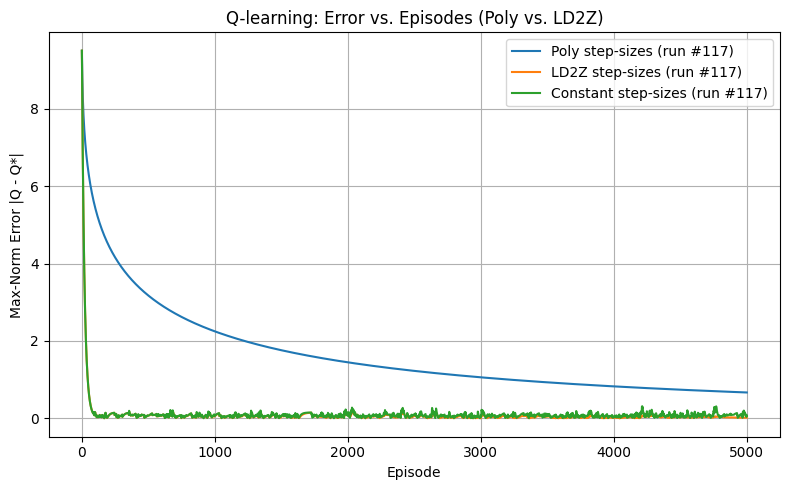

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle

# Load saved data
with open("all_error_history_poly.pkl", "rb") as f:
    all_error_history_poly = pickle.load(f)

#with open("final_Q_list.pkl", "rb") as f:
 #   final_Q_list = pickle.load(f)
    

# Load saved LD2Z histories
with open("all_error_history_ld2z.pkl", "rb") as f:
    all_error_history_ld2z = pickle.load(f)
    

with open("all_error_history_const.pkl", "rb") as f:
    all_error_history_const = pickle.load(f)
    
with open("all_error_history_pdtz_2.pkl", "rb") as f:
    all_error_history_pdtz_2 = pickle.load(f)
    
with open("all_error_history_pdtz_3.pkl", "rb") as f:
    all_error_history_pdtz_3 = pickle.load(f)
    
    

# Load environment and optimal Q*
env = GridworldEnv()
Q_star = compute_optimal_Q(env, gamma=gamma)

# Randomly select one run
B_poly = len(all_error_history_poly)
B_ld2z = len(all_error_history_ld2z)
B_const = len(all_error_history_const)
B_common = min(B_poly, B_ld2z, B_const)
idx = random.randint(0, B_common - 1)

err_poly = all_error_history_poly[idx]
err_ld2z = all_error_history_ld2z[idx]
err_const = all_error_history_const[idx]

plt.figure(figsize=(8, 5))
plt.plot(range(len(err_poly)), err_poly, label="Poly step-sizes (run #{})".format(idx))
plt.plot(range(len(err_ld2z)), err_ld2z, label="LD2Z step-sizes (run #{})".format(idx))
plt.plot(range(len(err_const)), err_const, label="Constant step-sizes (run #{})".format(idx))
plt.xlabel("Episode")
plt.ylabel("Max-Norm Error |Q - Q*|")
plt.title("Q-learning: Error vs. Episodes (Poly vs. LD2Z)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# (Optional) Mean curve across seeds, if you want a more stable picture:
# ---------------------------------------------------------------------
# def mean_curve(list_of_lists):
#     # Align by minimum length to avoid padding assumptions
#     min_len = min(len(x) for x in list_of_lists)
#     arr = np.array([x[:min_len] for x in list_of_lists], dtype=float)
#     return np.mean(arr, axis=0), np.std(arr, axis=0)

# mean_poly, std_poly = mean_curve(all_error_history_poly)
# mean_ld2z, std_ld2z = mean_curve(all_error_history_ld2z)

# x_poly = np.arange(len(mean_poly))
# x_ld2z = np.arange(len(mean_ld2z))

# plt.figure(figsize=(8, 5))
# plt.plot(x_poly, mean_poly, label="Poly (mean across seeds)")
# plt.fill_between(x_poly, mean_poly - std_poly, mean_poly + std_poly, alpha=0.2)
# plt.plot(x_ld2z, mean_ld2z, label="LD2Z (mean across seeds)")
# plt.fill_between(x_ld2z, mean_ld2z - std_ld2z, mean_ld2z + std_ld2z, alpha=0.2)
# plt.xlabel("Episode")
# plt.ylabel("Max-Norm Error |Q - Q*|")
# plt.title("Q-learning: Mean Error vs. Episodes (Poly vs. LD2Z)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Value iteration converged in 11 iterations with error 5.37e-10.


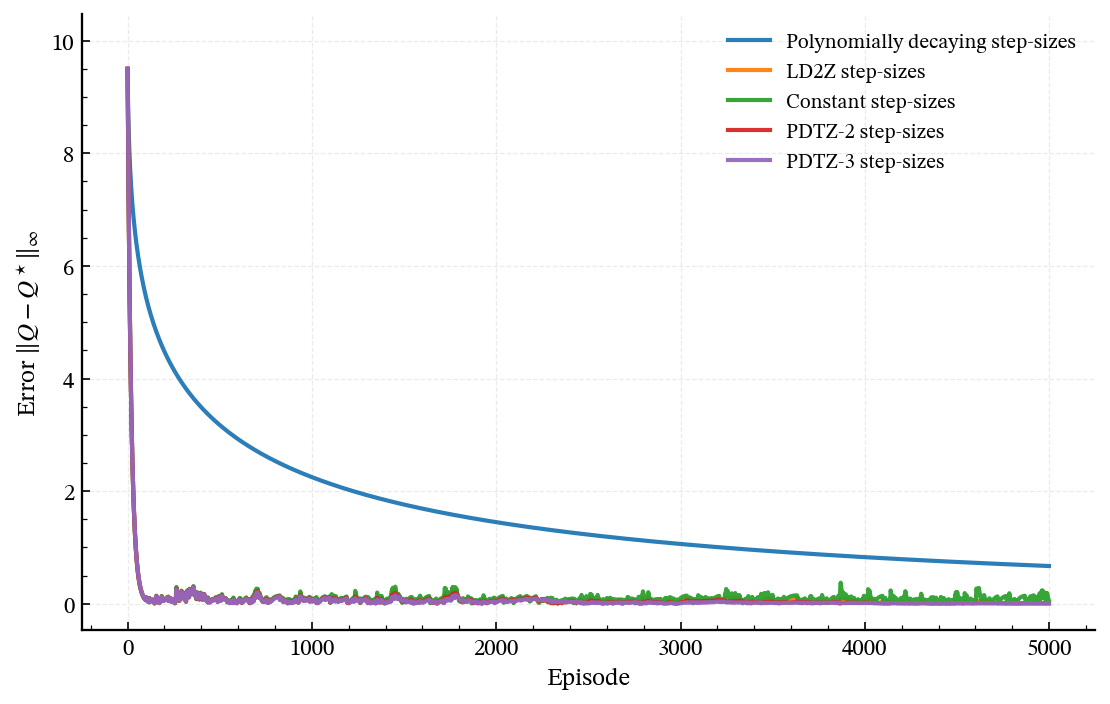

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle

# -----------------------------
# Minimal, modern, journal vibe
# -----------------------------
# Note: avoid text.usetex=True to keep it portable across machines.
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.family": "serif",
    "font.serif": ["STIX Two Text", "Times New Roman", "DejaVu Serif", "STIXGeneral", "CMU Serif"],
    "mathtext.fontset": "stix",
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1.1,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2.5,
    "ytick.minor.size": 2.5,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "figure.autolayout": False,  # we'll call tight_layout explicitly
    "text.usetex": False
})

# ----------------
# Load saved data
# ----------------
with open("all_error_history.pkl", "rb") as f:
    all_error_history = pickle.load(f)

with open("final_Q_list.pkl", "rb") as f:
    final_Q_list = pickle.load(f)

with open("all_error_history_ld2z.pkl", "rb") as f:
    all_error_history_ld2z = pickle.load(f)

# ----------------------------------------------------------
# If your code elsewhere defines these, this is a no-op here.
# The following lines assume you already have these defined:
#   - GridworldEnv, compute_optimal_Q, gamma
# ----------------------------------------------------------
try:
    env = GridworldEnv()
    Q_star = compute_optimal_Q(env, gamma=gamma)
except NameError:
    # Fall back gracefully if your environment helpers are defined elsewhere
    env = None
    Q_star = None


In [ ]:
std_poly

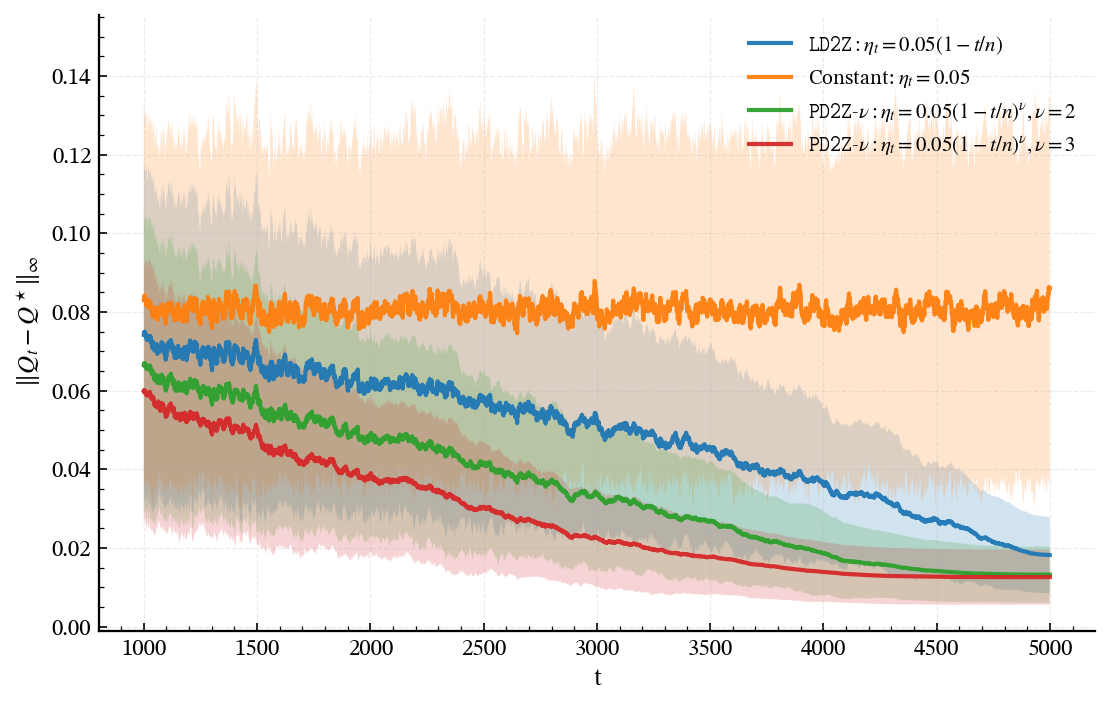

In [31]:
 # -----------------
# Choose range here
# -----------------
start, end = 1000, 5000   # example: plot episodes 100 to 999
# You can also set end=None to go till the end.

# Slice trajectories
x_poly = np.arange(len(mean_poly))[start:end]
x_ld2z = np.arange(len(mean_ld2z))[start:end]
x_const = np.arange(len(mean_const))[start:end]
x_pdtz_2 = np.arange(len(mean_pdtz_2))[start:end]
x_pdtz_3 = np.arange(len(mean_pdtz_3))[start:end]

err_poly_range = mean_poly[start:end]
err_ld2z_range = mean_ld2z[start:end]
err_const_range = mean_const[start:end]
err_pdtz_2_range = mean_pdtz_2[start:end]
err_pdtz_3_range = mean_pdtz_3[start:end]

std_poly_range = std_poly[start:end]
std_ld2z_range = std_ld2z[start:end]
std_const_range = std_const[start:end]
std_pdtz_2_range = std_pdtz_2[start:end]
std_pdtz_3_range = std_pdtz_3[start:end]

# -------------
# Ready to plot
# -------------
fig = plt.figure(figsize=(7.5, 4.8))
ax = plt.gca()

# LD2Z
ax.plot(x_ld2z, err_ld2z_range, linewidth=2.0, label=r"$\mathtt{LD2Z}: \eta_t =0.05 (1-t/n)$", alpha=0.95)
ax.fill_between(x_ld2z,
                err_ld2z_range - std_ld2z_range,
                err_ld2z_range + std_ld2z_range,
                alpha=0.2)

# Constant
ax.plot(x_const, err_const_range, linewidth=2.0, label="Constant: $\eta_t=0.05$", alpha=0.95)
ax.fill_between(x_const,
                err_const_range - std_const_range,
                err_const_range + std_const_range,
                alpha=0.2)

# PDTZ-2
ax.plot(x_pdtz_2, err_pdtz_2_range, linewidth=2.0, label=r"$\mathtt{PD2Z}$-$\nu: \eta_t =0.05 (1-t/n)^\nu, \nu=2$", alpha=0.95)
ax.fill_between(x_pdtz_2,
                err_pdtz_2_range - std_pdtz_2_range,
                err_pdtz_2_range + std_pdtz_2_range,
                alpha=0.2)

# PDTZ-3
ax.plot(x_pdtz_3, err_pdtz_3_range, linewidth=2.0, label=r"$\mathtt{PD2Z}$-$\nu: \eta_t =0.05 (1-t/n)^\nu, \nu=3$", alpha=0.95)
ax.fill_between(x_pdtz_3,
                err_pdtz_3_range - std_pdtz_3_range,
                err_pdtz_3_range + std_pdtz_3_range,
                alpha=0.2)

ax.set_xlabel("t")
ax.set_ylabel(r" $\|Q_t - Q^\star\|_\infty$")
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax * 1.05)
ax.minorticks_on()
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

fig.savefig("qlearning_error_pdtz2_vs_pdtz3_vs_ld2z_vs_const.png", bbox_inches="tight")


In [20]:
brew install mactex

SyntaxError: invalid syntax (3165273546.py, line 1)